# Test Performances

Notebook to analyse test performances, including :
- full-disk level performances
- patch/sector level performances
- center vs. limb pathes performances
- performances on windows where the activity differes from the previous one (AC-windows)
- performances on windows where the activity is the same as the previous one (NC-windows)
- persistent relative metrics

# Config

In [3]:
COLAB = False

if COLAB : 
  configSetup = {
      'COLAB'           : 'True',
      'PATH_ROOT_DRIVE' : '/content/drive/MyDrive/Projects/Forecast',
      'PATH_ROOT_LOCAL' : '/content/session',
      'PATH_SUNDL'      : '/content/sundl',
      'PATH_PROJECT'    : '/content/flare_limits_pcnn'
  }
  !git clone https://github.com/gfrancisco20/sundl.git
  !git clone https://github.com/gfrancisco20/flare_limits_pcnn.git
  import sys
  import re
  sys.path.append(configSetup['PATH_SUNDL'])
  sys.path.append(configSetup['PATH_PROJECT'])
  configFile = f'{configSetup["PATH_PROJECT"]}/config.py'
  with open(configFile, 'r') as file:
    content = file.read()
  for constant in configSetup.keys():
    content = re.sub(re.compile(f'{constant} = .*'), f'{constant} = \'{configSetup[constant]}\'', content)
  with open(configFile, 'w') as file:
    file.write(content)
   
from config import *
if COLAB:
  from sundl.utils.colab import mountDrive
  # mouting drive content in session on colab
  mountDrive()
  
# you must request the prediction  files  or recompute  them with folder 3  to run this  notebook

# Libraries

In [4]:
from glob import glob
import dill as pickle

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sundl.utils.data import read_Dataframe_With_Dates

# Setup

In [28]:
FOLDER = PATH_RES/'Classification_PCNN_224x448x3xCV05_2024_03_28__0' 

modelDict = {
  'C+_mpf_Persistent_24'                                        : 'C+_Persistence',
  'C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24'          : 'C+_PCNN_Blos', #
  'C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24': 'C+_PCNN_EUV',
  'M+_mpf_Persistent_24'                                        : 'M+_Persistence',
  'M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24': 'M+_PCNN_EUV',
  'M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24'          : 'M+_PCNN_Blos',
  'C+_PCNN_Both_Max'                                       : 'C+_PCNN_Both_Max',
  'M+_PCNN_Both_Max'                                       : 'M+_PCNN_Both_Max', 
  'C+_PCNN_Both_Avg'                                       : 'C+_PCNN_Both_Avg',
  'M+_PCNN_Both_Avg'                                       : 'M+_PCNN_Both_Avg' 
}

modelDictRev = {modelDict[oldName] : oldName for oldName in modelDict.keys()}

sns.set(style="whitegrid")

# Full Disk Performances

## Load predictions

In [29]:
%%time
from config import F_PATH_PREDS_MODEL
fdPredictions = {}
for modelNameFull in modelDict.keys():
  modelName = modelNameFull # modelDict[modelNameFull]
  pathPredFd_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'fd', True)
  if pathPredFd_withLabels.exists():
    fdPredictions[modelName] = read_Dataframe_With_Dates(pathPredFd_withLabels)
  else:
    pathPredFd = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'fd', False)
    if pathPredFd.exists():
      fdPredictions[modelName] = read_Dataframe_With_Dates(pathPredFd)
      fdPredictions[modelName]['histo'] = fdPredictions[modelName]['label'].rolling(window = f'{24}H',
                                        closed = 'left', # min_periods = int(input_lag)
                                        ).apply(
                                          lambda x: x[0])
      fdPredictions[modelName]['change'] = fdPredictions[modelName]['histo'] != fdPredictions[modelName]['label']
      fdPredictions[modelName].to_csv(pathPredFd_withLabels)

CPU times: user 1.37 s, sys: 86.7 ms, total: 1.45 s
Wall time: 1.65 s


## Compute Performances

In [31]:
%%time
from utilsTest import fullDiskPerformance

startingDates = pd.date_range(start = datetime.datetime(2020,1,1), end = datetime.datetime(2023,1,1), freq = '31D').to_pydatetime().tolist()
filterNames   = ['all','windowChanging', 'windowConstant']
includeFolds  = True

perfTest_Variations = fullDiskPerformance(fdPredictions.copy(), 
                               startingDates, 
                               filterNames, 
                               includeFolds,
                               pThds = [0.5]
                               ).copy()

/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTest = pd.concat([perfTest,pd.DataFrame({
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:144: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:144: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:144: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:144: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)
/Users/greg/P

CPU times: user 28.9 s, sys: 493 ms, total: 29.4 s
Wall time: 30.3 s


# Dataset  composition sensitivity

## Standard metrics

In [13]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

Text(0.5, 0, 'positive event ratio')

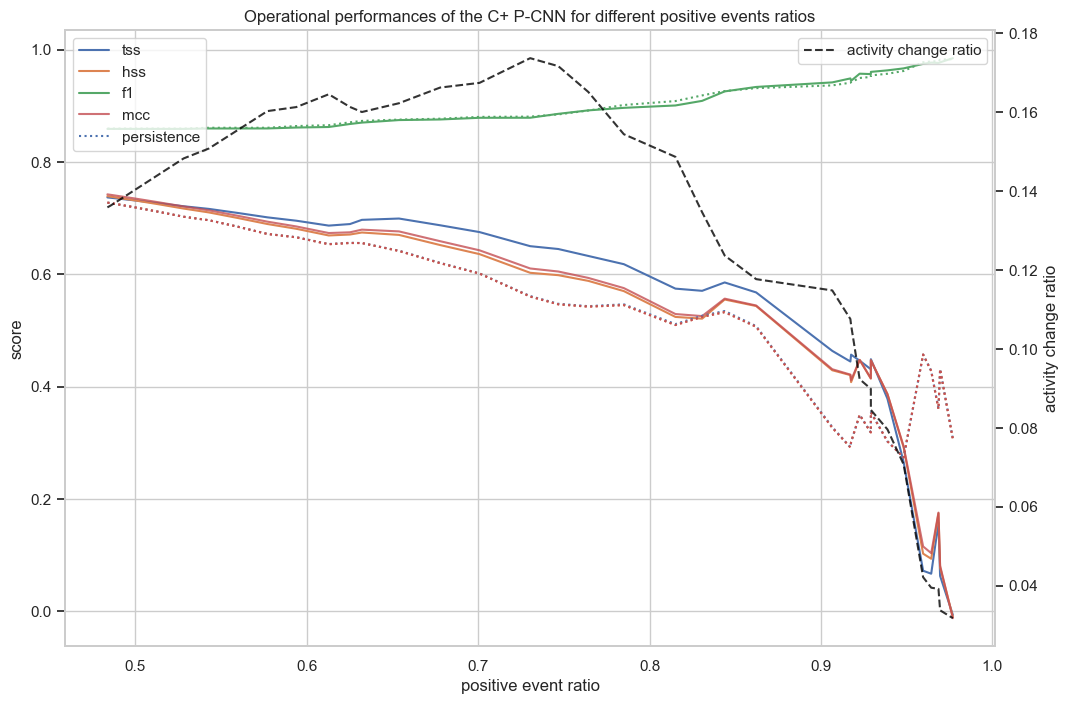

In [32]:
modelTypes = 'C'
subtype    = 'euv'

cls =  modelTypes
perf = perfTest_Variations[perfTest_Variations['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]!='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})
persistent = perfTest_Variations[perfTest_Variations['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]=='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})

if subtype == 'euv':
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='0193x0211x0094')].copy()
else:
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='blos')].copy()

filter = 'all'
foldId = 'avg'
perf  = perf[((perf['modelFdId']==foldId) & (perf['filter']==filter))]
persistent  = persistent[((persistent['modelFdId']==foldId) & (persistent['filter']==filter))]


x = perf['test_start_date']
x = perf['bal_pos']
# x = perf['switch_rate']
# x = 1 / (perf['switch_rate']/4 + perf['bal_pos'] )
# x = -np.power(x,-8)

p = perf['bal_pos'] #* perf['tot']
c = perf['switch_rate']# * perf['tot']
# x = - (p-c/2) / (p)
# # x = 1 - c/(2*p)
# # x = -x
# # x = 1/x
# x = (p-c/2)

# x = (p-c/2) / (p)
# x = p

left = c

# x = (1-p)*(1-c)

ax = sns.lineplot(x = x , y = perf['tss'].values, label = 'tss')
sns.lineplot(x = x , y = perf['hss'].values, label = 'hss', ax = ax)
sns.lineplot(x = x , y = perf['f1'].values, label = 'f1', ax = ax)
sns.lineplot(x = x , y = perf['mcc'].values, label = 'mcc', ax = ax, alpha = 0.8)
# sns.lineplot(x = x , y = perf['recall'], label = 'recall', ax = ax)
# sns.lineplot(x = x, y = perf['precision'], label = 'precision', ax = ax)


# sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, color = 'black')
sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, linestyle=':', color = ax.lines[0].get_color())
sns.lineplot(x = x , y = persistent['hss'].values, ax = ax, linestyle=':', color = ax.lines[1].get_color())
sns.lineplot(x = x, y = persistent['f1'].values, ax = ax, linestyle=':', color = ax.lines[2].get_color())
sns.lineplot(x = x, y = persistent['mcc'].values, ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['recall'], ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['precision'], ax = ax, linestyle=':', color = ax.lines[4].get_color())

tnr =   perf['tn'] / ( perf['tn']+ perf['fp'])
# sns.lineplot(x = x, y = tnr, label = 'tnr', ax = ax)


ax.set_ylabel('score')
ax.set_xlabel('starting date of the test set')


ax2 = ax.twinx()
ax2.grid(visible=None)
# sns.lineplot(x = x , y = perf['bal_pos'], label = 'positive events balance' , ax = ax2, color = 'black', alpha = 0.8)
sns.lineplot(x = x , y = left, label = 'activity change ratio', ax = ax2, color = 'black', alpha=0.8)
# sns.lineplot(x = x, y = persistent['f1'], ax = ax2, linestyle=':', color = ax.lines[2].get_color())
for line in ax2.lines:
  line.set_linestyle("--")
ax2.lines[0].set_linestyle("--")
ax2.legend(loc='upper right')
ax2.set_ylabel('activity change ratio')


plt.title(f'Operational performances of the {cls}+ P-CNN for different positive events ratios')

ax.legend(loc='upper left')

ax.set_xlabel('positive event ratio')



## Persistent relative metrics

Text(0.5, 0, 'positive event ratio')

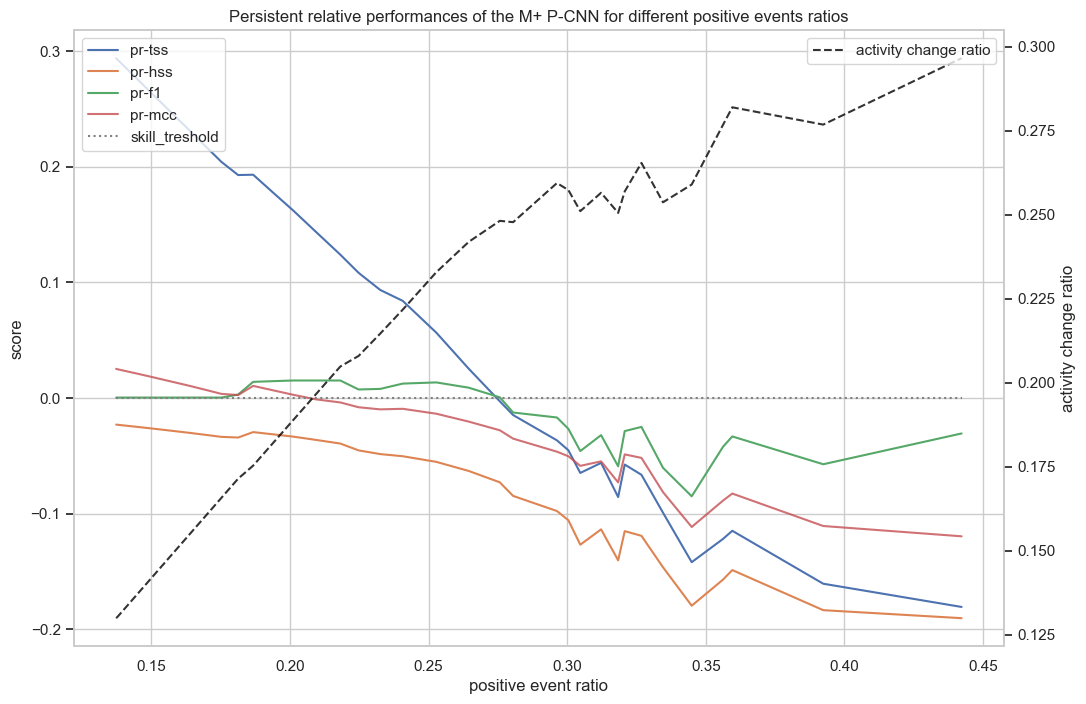

In [34]:
modelTypes = 'M'
subtype    = 'euv'

cls =  modelTypes
perf = perfTest_Variations[perfTest_Variations['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]!='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})
persistent = perfTest_Variations[perfTest_Variations['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]=='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})

if subtype == 'euv':
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='0193x0211x0094')].copy()
else:
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='blos')].copy()

filter = 'all'
foldId = 'avg'
perf  = perf[((perf['modelFdId']==foldId) & (perf['filter']==filter))]
persistent  = persistent[((persistent['modelFdId']==foldId) & (persistent['filter']==filter))]


x = perf['test_start_date']
# x = perf['bal_pos']
# x = perf['switch_rate']
# x = 1 / (perf['switch_rate']/4 + perf['bal_pos'] )
# x = -np.power(x,-8)

p = perf['bal_pos'] #* perf['tot']
c = perf['switch_rate']# * perf['tot']
# # x = - (p-c/2) / (p)
# # x = 1 - c/(2*p)
# # x = -x
# # x = 1/x
# x = (p-c/2)

# x = (p-c/2) / (p)
x = p

left = c


prss = {}
sup = 1
for mtc in ['tss','hss','mcc','f1']:
  s = perf[mtc].values
  ref = persistent[mtc].values
  prscore = s - ref
  if mtc in ['f1']:
    inf = 0
  else:
    inf = -1
  posIdxs = prscore>=0
  negIdxs = prscore<0
  prscore[posIdxs] = prscore[posIdxs] / np.abs(sup - ref[posIdxs])
  prscore[negIdxs] = prscore[negIdxs] / np.abs(inf - ref[negIdxs])
  prss[mtc] = prscore


ax = sns.lineplot(x = x , y = prss['tss'], label = 'pr-tss')
sns.lineplot(x = x , y = prss['hss'], label = 'pr-hss', ax = ax)
sns.lineplot(x = x , y = prss['f1'], label = 'pr-f1', ax = ax)
sns.lineplot(x = x , y = prss['mcc'], label = 'pr-mcc', ax = ax, alpha = 0.8)
# sns.lineplot(x = x , y = perf['recall'], label = 'recall', ax = ax)
# sns.lineplot(x = x, y = perf['precision'], label = 'precision', ax = ax)


# sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, color = 'black')
# sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, linestyle=':', color = ax.lines[0].get_color())
# sns.lineplot(x = x , y = persistent['hss'].values, ax = ax, linestyle=':', color = ax.lines[1].get_color())
# sns.lineplot(x = x, y = persistent['f1'].values, ax = ax, linestyle=':', color = ax.lines[2].get_color())
# sns.lineplot(x = x, y = persistent['mcc'].values, ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['recall'], ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['precision'], ax = ax, linestyle=':', color = ax.lines[4].get_color())

tnr =   perf['tn'] / ( perf['tn']+ perf['fp'])
# sns.lineplot(x = x, y = tnr, label = 'tnr', ax = ax)


ax.set_ylabel('score')
ax.set_xlabel('starting date of the test set')

sns.lineplot(x = x , y = np.zeros(len(perf)) , label = 'skill_treshold', ax = ax, color = 'gray')
ax.lines[-1].set_linestyle(":")

ax2 = ax.twinx()
ax2.grid(visible=None)
# sns.lineplot(x = x , y = perf['bal_pos'], label = 'positive events balance' , ax = ax2, color = 'black', alpha = 0.8)
sns.lineplot(x = x , y = left, label = 'activity change ratio', ax = ax2, color = 'black', alpha=0.8)
# sns.lineplot(x = x, y = persistent['f1'], ax = ax2, linestyle=':', color = ax.lines[2].get_color())
for line in ax2.lines:
  line.set_linestyle("--")
ax2.lines[0].set_linestyle("--")
ax2.legend(loc='upper right')
ax2.set_ylabel('activity change ratio')


plt.title(f'Persistent relative performances of the {cls}+ P-CNN for different positive events ratios')

ax.legend(loc='upper left')

ax.set_xlabel('positive event ratio')



# Thresholding

## First dataset composition

In [35]:
perfTest_Thresholding = fullDiskPerformance(fdPredictions.copy(), 
                               [datetime.datetime(2020,1,28)], 
                               filterNames, 
                               includeFolds,
                               pThds = np.arange(0,1.05,0.05)
                               ).copy()


/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTest = pd.concat([perfTest,pd.DataFrame({
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:

(0.2, 1.0)

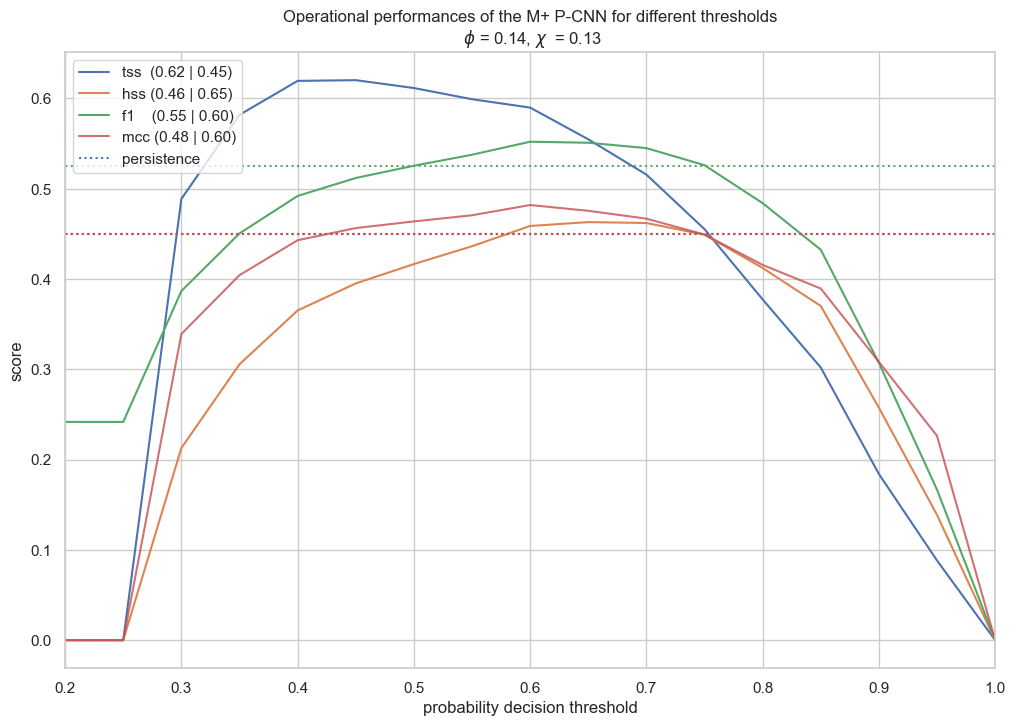

In [36]:
modelTypes = 'M'
subtype    = 'euv'

cls =  modelTypes
perf = perfTest_Thresholding[perfTest_Thresholding['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]!='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})
persistent = perfTest_Thresholding[perfTest_Thresholding['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]=='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})

if subtype == 'euv':
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='0193x0211x0094')].copy()
else:
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='blos')].copy()

filter = 'all'
foldId = 'avg'
perf  = perf[((perf['modelFdId']==foldId) & (perf['filter']==filter))]
persistent  = persistent[((persistent['modelFdId']==foldId) & (persistent['filter']==filter))]


x = perf['thd']


p = perf['bal_pos'] #* perf['tot']
c = perf['switch_rate']# * perf['tot']

left = c

# x = (1-p)*(1-c)

ax = sns.lineplot(x = x , y = perf['tss'].values, label = f'tss  ({perf["tss"].values.max():.2f} | {x.iloc[perf["tss"].values.argmax()]:.2f})')
sns.lineplot(x = x , y = perf['hss'].values, label = f'hss ({perf["hss"].values.max():.2f} | {x.iloc[perf["hss"].values.argmax()]:.2f})', ax = ax)
sns.lineplot(x = x , y = perf['f1'].values, label = f'f1    ({perf["f1"].values.max():.2f} | {x.iloc[perf["f1"].values.argmax()]:.2f})', ax = ax)
sns.lineplot(x = x , y = perf['mcc'].values, label = f'mcc ({perf["mcc"].values.max():.2f} | {x.iloc[perf["mcc"].values.argmax()]:.2f})', ax = ax, alpha = 0.8)
# sns.lineplot(x = x , y = perf['recall'], label = 'recall', ax = ax, color = 'olive')
# sns.lineplot(x = x, y = perf['precision'], label = 'precision', ax = ax, color = 'darkolivegreen')


# sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, color = 'black')
sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, linestyle=':', color = ax.lines[0].get_color())
sns.lineplot(x = x , y = persistent['hss'].values, ax = ax, linestyle=':', color = ax.lines[1].get_color())
sns.lineplot(x = x, y = persistent['f1'].values, ax = ax, linestyle=':', color = ax.lines[2].get_color())
sns.lineplot(x = x, y = persistent['mcc'].values, ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['recall'], ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['precision'], ax = ax, linestyle=':', color = ax.lines[4].get_color())

tnr =   perf['tn'] / ( perf['tn']+ perf['fp'])
# sns.lineplot(x = x, y = tnr, label = 'tnr', ax = ax)


ax.set_ylabel('score')
ax.set_xlabel('starting date of the test set')



plt.title(f'Operational performances of the {cls}+ P-CNN for different thresholds\n $\phi$ = {p.max():.2f}, $\chi$  = {c.max():.2f}')

ax.legend(loc='upper left')

ax.set_xlabel('probability decision threshold')

ax.set_xlim(left=0.2, right =1)

## Alternative dataset composition

In [37]:
perfTest_Thresholding = fullDiskPerformance(fdPredictions.copy(), 
                               [datetime.datetime(2023,1,1)], 
                               filterNames, 
                               includeFolds,
                               pThds = np.arange(0,1.05,0.05)
                               ).copy()

/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTest = pd.concat([perfTest,pd.DataFrame({
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:

/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:139: RuntimeWarning: invalid valu

(0.2, 1.0)

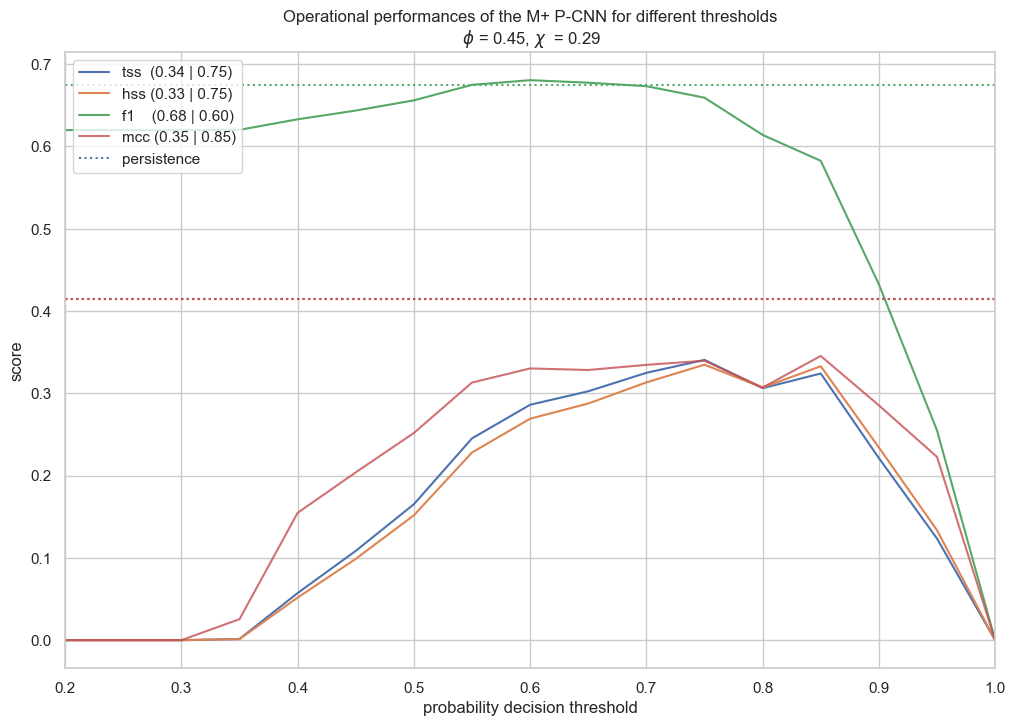

In [38]:
modelTypes = 'M'
subtype    = 'euv'

cls =  modelTypes
perf = perfTest_Thresholding[perfTest_Thresholding['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]!='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})
persistent = perfTest_Thresholding[perfTest_Thresholding['model'].apply(lambda x: x[0]==modelTypes[0] and x.split('_')[2][:3]=='Per')].copy().fillna(0).rename(columns = {'startingDate':'test_start_date'})

if subtype == 'euv':
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='0193x0211x0094')].copy()
else:
  perf = perf[perf['model'].apply(lambda x: x.split('_')[-2]=='blos')].copy()

filter = 'all'
foldId = 'avg'
perf  = perf[((perf['modelFdId']==foldId) & (perf['filter']==filter))]
persistent  = persistent[((persistent['modelFdId']==foldId) & (persistent['filter']==filter))]


x = perf['thd']


p = perf['bal_pos'] #* perf['tot']
c = perf['switch_rate']# * perf['tot']

left = c

# x = (1-p)*(1-c)

ax = sns.lineplot(x = x , y = perf['tss'].values, label = f'tss  ({perf["tss"].values.max():.2f} | {x.iloc[perf["tss"].values.argmax()]:.2f})')
sns.lineplot(x = x , y = perf['hss'].values, label = f'hss ({perf["hss"].values.max():.2f} | {x.iloc[perf["hss"].values.argmax()]:.2f})', ax = ax)
sns.lineplot(x = x , y = perf['f1'].values, label = f'f1    ({perf["f1"].values.max():.2f} | {x.iloc[perf["f1"].values.argmax()]:.2f})', ax = ax)
sns.lineplot(x = x , y = perf['mcc'].values, label = f'mcc ({perf["mcc"].values.max():.2f} | {x.iloc[perf["mcc"].values.argmax()]:.2f})', ax = ax, alpha = 0.8)
# sns.lineplot(x = x , y = perf['recall'], label = 'recall', ax = ax, color = 'olive')
# sns.lineplot(x = x, y = perf['precision'], label = 'precision', ax = ax, color = 'darkolivegreen')


# sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, color = 'black')
sns.lineplot(x = x, y = persistent['tss'].values, label = 'persistence', ax = ax, linestyle=':', color = ax.lines[0].get_color())
sns.lineplot(x = x , y = persistent['hss'].values, ax = ax, linestyle=':', color = ax.lines[1].get_color())
sns.lineplot(x = x, y = persistent['f1'].values, ax = ax, linestyle=':', color = ax.lines[2].get_color())
sns.lineplot(x = x, y = persistent['mcc'].values, ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['recall'], ax = ax, linestyle=':', color = ax.lines[3].get_color())
# sns.lineplot(x = x , y = persistent['precision'], ax = ax, linestyle=':', color = ax.lines[4].get_color())

tnr =   perf['tn'] / ( perf['tn']+ perf['fp'])
# sns.lineplot(x = x, y = tnr, label = 'tnr', ax = ax)


ax.set_ylabel('score')
ax.set_xlabel('starting date of the test set')



plt.title(f'Operational performances of the {cls}+ P-CNN for different thresholds\n $\phi$ = {p.max():.2f}, $\chi$  = {c.max():.2f}')

ax.legend(loc='upper left')

ax.set_xlabel('probability decision threshold')

ax.set_xlim(left=0.2, right =1)